## Outline of work

* HVC archicture produces sequential dynamics, and burst timing of individual PNs is well explained by a uniform distribution over the motif.

    1. **From Lynch et al., 2016**: "By simulating a large number (104) of surrogate datasets, we found that the observed covered fraction for all birds was consistent with random sampling from a uniform underlying distribution of burst times (uniform model; Fig- ure 2A; p > 0.05 for all birds). Note that this does not imply that the bursts are truly uniformly distributed, only that the observed coverage metric is consistent with random burst placement."
    
    
* Some PNs neurons do not fire during the motif.

    1. Something like 20-40% found not to participate during the motif. Should look up this number.
    
    
* Withholding some fraction of PNs from being integrated into the sequence could be a resilience feature. This allows backfilling of portions of the chain that grow most damaged.

    1. There are two strategies here:
    
        1. Spread all available neurons uniformly across L layers of a chain.
        
        2. Spread some fraction of available neurons uniformly across L layers of a chain. Withhold the remaining fraction. After perturbation, backfill the *most damaged* layers with some fraction of the withheld neurons. Repeat this process.
        
* Gap junctional couplings:

  1. From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4448602/": As early as 8 d following birth, new neurons that express neuronal markers but are not yet fully mature and functional can be found in HVC (Fig. 2) (Kirn et al. 1999). At the end of migration, these new neurons form close contact with the soma of mature HVC neurons (Burd and Nottebohm 1985). These new cells integrate into functional circuits, and form somatal contact with mature HVC interneurons and neurons that project to area X (HVCX) and RA (HVCRA) (Fig. 2) (Kirn et al. 1999; Scott et al. 2012). These cellular interactions may provide a “stop” signal that terminates migration (Scott et al. 2012). Together, the new and mature neurons form clusters that may represent a functional unit (Kirn et al. 1999). The neurons within these clusters appear to be connected by gap junctions (Gahr and Garcia-Segura 1996). This coupling may allow HVCX neurons to entrain new HVCRA neurons to produce the appropriate motor pattern for song production (Alvarez-Buylla and Kim 1997)."
  
  1. From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8615078/: GJD2 mRNA encodes for gap junctional couplings in vertebrates. In canary HVC, it is the interneurons that mostly possess this gene, with HVC(RA) cells sparsely expressing it as well. Interneurons that express it are often clumped together.
  
  1. From same source as above: "Inspection of a single-cell sequencing database from zebra and Bengalese finches generalizes the distributions of electrical synapses across cell types and song nuclei that we found in HVC and RA from canaries, reveals a differential GJD2 mRNA expression in HVC glutamatergic subtypes and its transient increase along the neurogenic lineage."

### Figure 1 - Comparison of resilience strategies

* Panel 1: cartoon illustration of stategy A 
* Panel 2: cartoon illustration of stategy B
* Panel 3: resilience curves for strategies A & B under different numbers of withheld neurons.
* Panel 4: dependence on L, N, withheld percentage


### Figure 2 - Layout mechanism for incorporating new cells

* Panel 1: Inhibition closely follows excitation in sequences
* Panel 2: New cells strongly coupled to excitation weakly to excitation can learn where they are needed
* Panel 3: Synapse addition makes neurons more "spontaneously excitable" in period of time with no inhibition

### Figure 3 - Implementation in spiking network (build this)

* Panel 1: schematic showing structure of network
* Panel 2: description of plasticity rules assumed to exist. Firing rate homeostasis of a sort.
* Panel 3: triplet plasticity
* Panel 4: networks are stable normally


### Figure 4 - Results of implementation in spiking network

* Panel 1: gaps in inhibition teach silent neurons where to enter
* Panel 2: calculate some correlation between inhibition and new cell activity
* Panel 3: "" with excitation and new cell entry
* Panel 4: estimation of efficiency?


### Figure 5 - Redo theoretical calculation with spiking neural network

### Figure 6 - Theory?




In [122]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from functools import partial
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from sympy.utilities.iterables import multiset_permutations

%matplotlib notebook

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

def set_font_size(ax, font_size, legend_font_size=None):
    """Set font_size of all axis text objects to specified value."""

    texts = [ax.title, ax.xaxis.label, ax.yaxis.label] + \
        ax.get_xticklabels() + ax.get_yticklabels()

    for text in texts:
        text.set_fontsize(font_size)

    if ax.get_legend():
        if not legend_font_size:
            legend_font_size = font_size
        for text in ax.get_legend().get_texts():
            text.set_fontsize(legend_font_size)

In [21]:
def least_bucket_repair(net_arr, n_remaining, per_to_use):
    n_to_use = int(per_to_use * n_remaining)
    
    for i in range(n_to_use):
        min_idx = np.argmin(net_arr)
        net_arr[min_idx] += 1
        
    return net_arr, n_remaining - n_to_use

def run_sim(net_arr, p, n_remaining, f_network_repair=None):
    successes = 0
    for i in range(1000):
        net_arr = np.random.binomial(net_arr, p)
        if (net_arr >= THRESH).all():
            successes += 1
        else:
            break
        if f_network_repair is not None:
            net_arr, n_remaining = f_network_repair(net_arr, n_remaining)
    return successes, net_arr

def simulate_multiple_usage_rates(usage_rates, perturbation_rates, initial_per_to_use, use_repair=False):
    successes_for_all_usage_rates = []
    
    for k, per_to_use in enumerate(usage_rates):
        network_arr = initial_per_to_use * (N/L) * np.ones(L)
        network_arr = network_arr.astype(int)
        n_remaining = N - np.sum(network_arr)

        if use_repair:
            repair_func = partial(least_bucket_repair, per_to_use=per_to_use)

        success_rates = []

        for p in perturbation_rates:
            all_successes = []

            for j in range(1000):
                if use_repair:
                    successes, net_arr = run_sim(network_arr, p, n_remaining, f_network_repair=repair_func)
                else:
                    successes, net_arr = run_sim(network_arr, p, n_remaining)
                
                all_successes.append(successes)

            success_rates.append(np.mean(all_successes))
        
        successes_for_all_usage_rates.append(success_rates)
    return successes_for_all_usage_rates

In [26]:
N = 10 * 20
L = 10
THRESH = 1

usage_rates = np.linspace(0.05, 0.5, 7)
all_p = np.linspace(0.5, 0.95, 100)

success_rates = simulate_multiple_usage_rates(usage_rates, all_p, 0.6, use_repair=True)
success_rates_control = simulate_multiple_usage_rates(usage_rates, all_p, 1.0, use_repair=False)

<IPython.core.display.Javascript object>


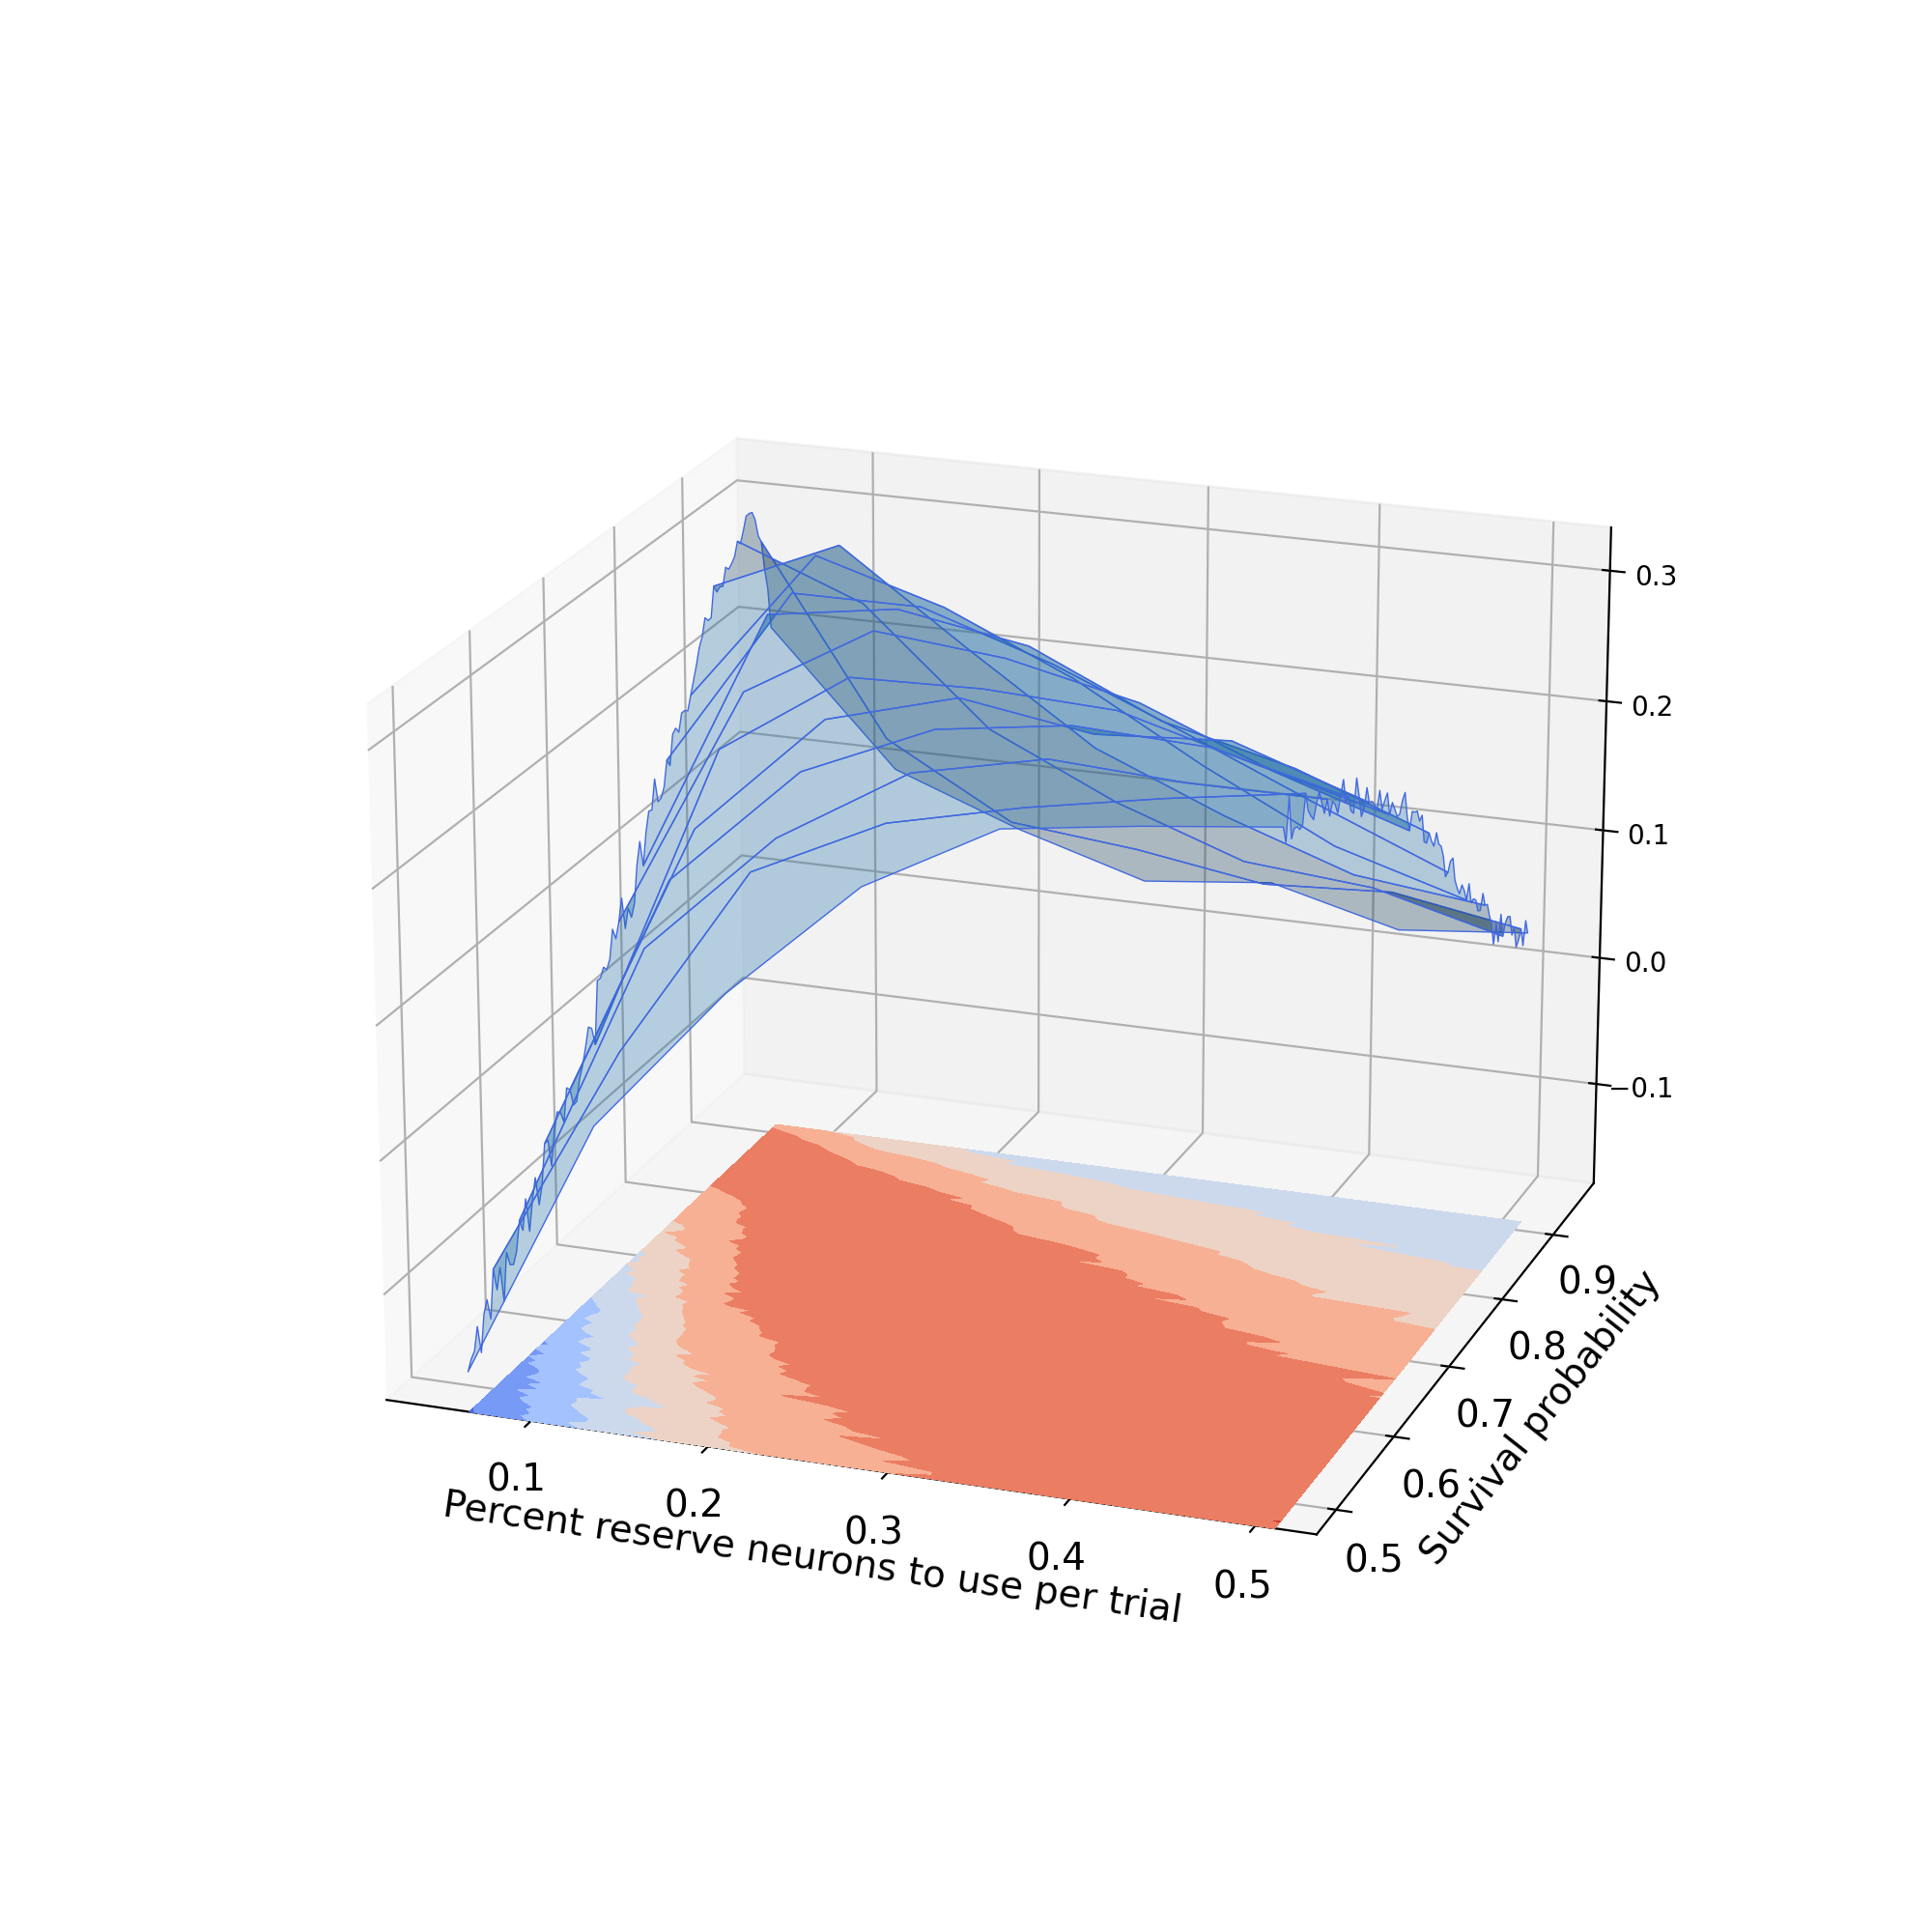

In [46]:
# colors = get_ordered_colors('winter', 20)

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

x, y = np.meshgrid(usage_rates, all_p)

survival_percent_change = (np.array(success_rates).T - np.array(success_rates_control).T) / np.array(success_rates).T

ax.plot_surface(x, y, survival_percent_change, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)

# ax.plot_surface(x, y, np.array(success_rates_control).T, edgecolor='grey', lw=0.5, rstride=8, cstride=8, alpha=0.3)

ax.contourf(x, y, survival_percent_change, zdir='z', cmap='coolwarm', offset=-0.2)
# ax.contourf(x, y, np.array(success_rates).T, zdir='x', cmap='coolwarm', offset=)
# ax.contourf(x, y, np.array(success_rates).T, zdir='y', cmap='coolwarm', offset=)

ax.set_xlabel('Percent reserve neurons to use per trial')
ax.set_ylabel('Survival probability')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
set_font_size(ax, 14)



$$\frac{<t> - <t_c>}{<t_c>} $$

In [97]:
def state_tuple_to_idx(n_1, n_2):
    return int((n_1 * (n_1 + 1))/2 + n_2)

def construct_repair_matrix(n_max, k):
    idx = 0
    states = []
    for n_1 in range(n_max + 1):
        for n_2 in range(n_1 + 1):
            states.append((n_1, n_2))
    #         print(idx, state_tuple_to_idx(n_1, n_2))
            idx += 1
    
    repair_matrix = np.zeros((len(states), len(states)))
    for i, outgoing_state in enumerate(states):
        (n_1, n_2) = outgoing_state

        if n_1 - n_2 >= k:
            if n_2 + k > n_max:
                repair_matrix[i, state_tuple_to_idx(n_1, n_max)] = 1
            else:
                repair_matrix[i, state_tuple_to_idx(n_1, n_2 + k)] = 1
        else:
            sum_plus_k = n_1 + n_2 + k
            if sum_plus_k % 2 == 0:
                j = state_tuple_to_idx(sum_plus_k / 2, sum_plus_k / 2)
            else:
                j = state_tuple_to_idx((sum_plus_k + 1) / 2, (sum_plus_k - 1) / 2)
            if j >= len(states):
                j = len(states) - 1
            repair_matrix[i, j] = 1
    
    return repair_matrix, states

<IPython.core.display.Javascript object>


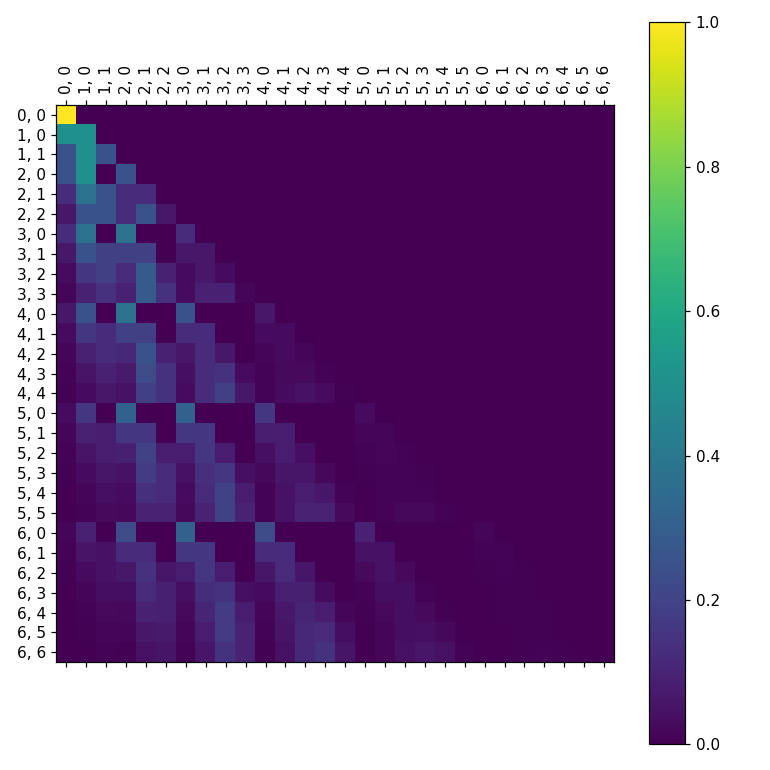

<IPython.core.display.Javascript object>


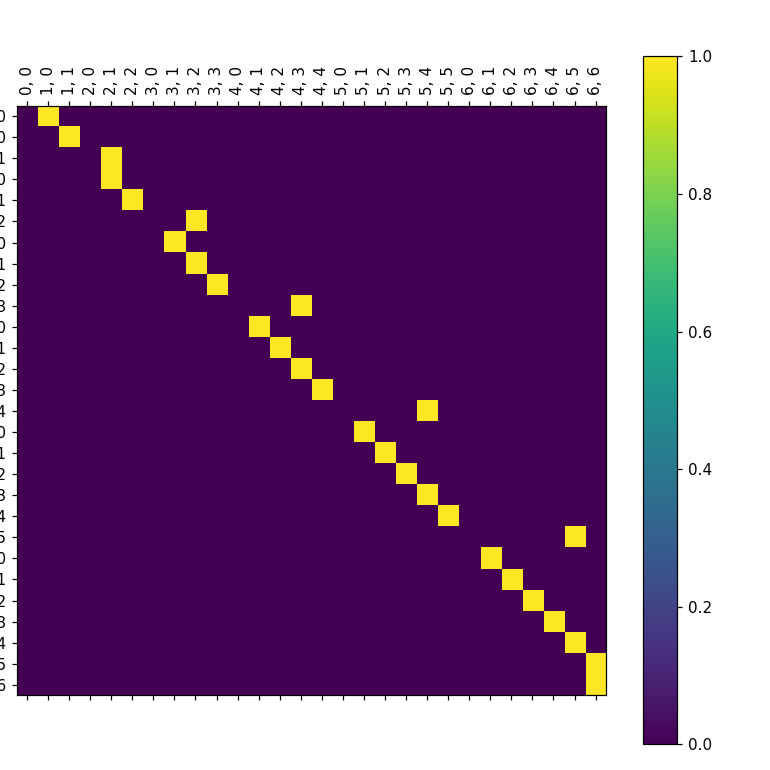

<IPython.core.display.Javascript object>


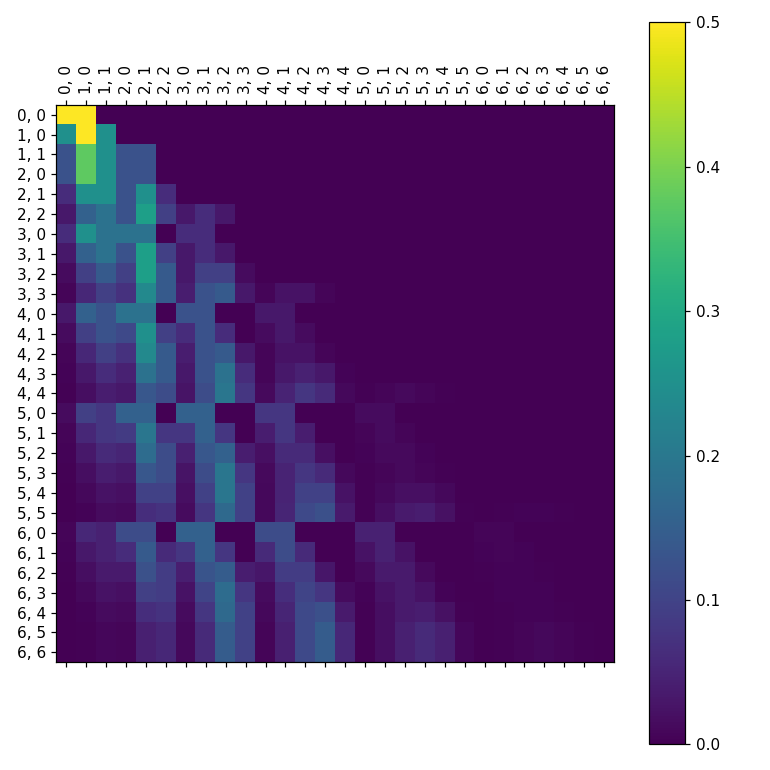

In [186]:
from scipy.stats import norm
from scipy.special import comb

def comb_zg(n, k):
    if n == 0:
        return 0
    else:
        return comb(n, k)

def construct_perturbation_matrix(n_max, p):
    idx = 0
    states = []
    for n_1 in range(n_max + 1):
        for n_2 in range(n_1 + 1):
            states.append((n_1, n_2))
            idx += 1
            
    perb_matrix = np.zeros((len(states), len(states)))
    
    for i, outgoing_state in enumerate(states):
        (n_1, n_2) = outgoing_state
        for j, incoming_state in enumerate(states):
            (n_1_prime, n_2_prime) = incoming_state
            
            if n_1_prime == n_2_prime:
                perb_matrix[i, j] = comb(n_1, n_1_prime) * comb(n_2, n_2_prime)
            else:  
                perb_matrix[i, j] = (comb(n_1, n_1_prime) * comb(n_2, n_2_prime) + comb(n_1, n_2_prime) * comb(n_2, n_1_prime))
            perb_matrix[i, j] *= (np.power(p, n_1_prime + n_2_prime) * np.power(1 - p, n_1 + n_2 - n_1_prime - n_2_prime))
    return perb_matrix

def state_label(state):
    return ', '.join([f'{n}' for n in state])

def display_mat(mat, states, scale=1):
    fig = plt.figure(figsize=(7 * scale, 7 * scale), tight_layout=True)
    axs = fig.add_subplot()
    mappable = axs.matshow(mat)

    axs.set_xticks(np.arange(len(states)))
    axs.set_xticklabels([state_label(state) for state in states], rotation=90)
    axs.set_yticks(np.arange(len(states)))
    axs.set_yticklabels([state_label(state) for state in states])

    plt.colorbar(mappable, ax=axs)
    
perb_matrix = construct_perturbation_matrix(6, 0.5)
repair_matrix, states = construct_repair_matrix(6, 1)

display_mat(perb_matrix, states)
display_mat(repair_matrix, states)
display_mat(np.dot(repair_matrix, perb_matrix), states)


In [156]:
def prob_transition_perturb(sending_state, receiving_state, p):
    sending_sum = np.sum(sending_state)
    receiving_sum = np.sum(receiving_state)
    
    prefactor = np.power(p, receiving_sum) * np.power(1 - p, sending_sum - receiving_sum)
    unique_perms_receiving = list(multiset_permutations(receiving_state))
    perm_sum = 0
    for perm in unique_perms_receiving:
        perm_sum += np.prod([comb(n_in, n_out) for n_in, n_out in zip(sending_state, perm)])
        
    return prefactor * perm_sum

In [189]:
def construct_states(n_buckets, bucket_max, partial_state=[], states=[]):
    if len(partial_state) == n_buckets:
        states.append(partial_state)
    else:
        if len(states) == 0:
            iter_max = bucket_max
        else:
            iter_max = partial_state[-1]
        for i in range(iter_max + 1):
            construct_states(n_buckets, i, copy(partial_state) + [i], states=states)

def construct_perturbation_matrix_2(n_buckets, bucket_max, p, k=0):
    idx = 0
    states = []
    construct_states(n_buckets, bucket_max, states=states)
            
    perb_matrix = np.zeros((len(states), len(states)))
    
    for i, sending_state in enumerate(states):
        if sending_state[-1] != bucket_max:
            sending_state = copy(sending_state)
            sending_state[-1] += k
        for j, receiving_state in enumerate(states):
            perb_matrix[i, j] = prob_transition_perturb(sending_state, receiving_state, p)
    return perb_matrix, states

def n_th_power_mat(mat, n):
    working_mat = np.eye(*mat.shape)
    for i in range(n):
        working_mat = np.dot(working_mat, mat)
    return working_mat

<IPython.core.display.Javascript object>


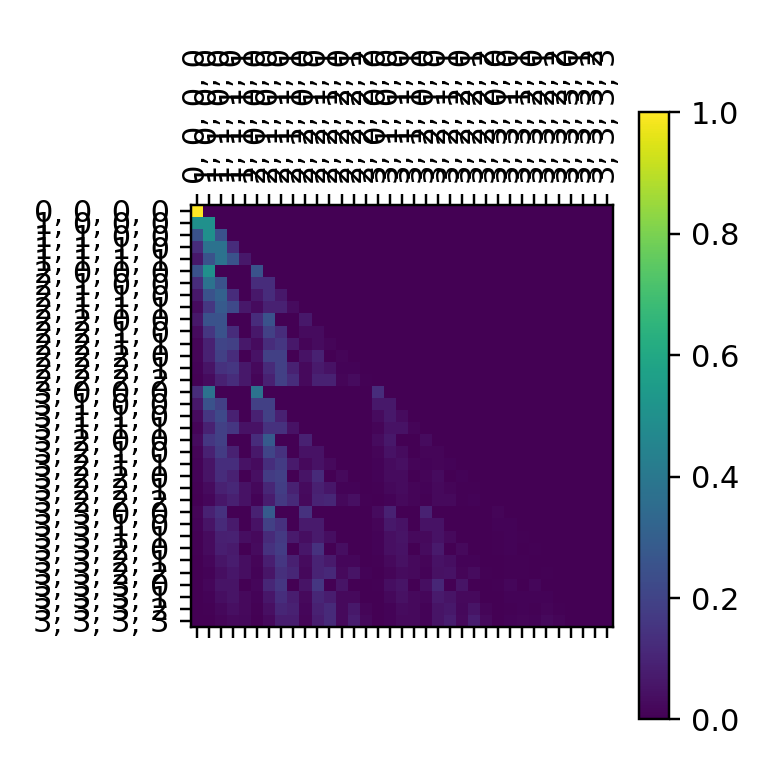

In [192]:
perb_matrix_2, states = construct_perturbation_matrix_2(4, 3, 0.5)
display_mat(n_th_power_mat(perb_matrix_2, 1), states, scale=0.5)

<IPython.core.display.Javascript object>


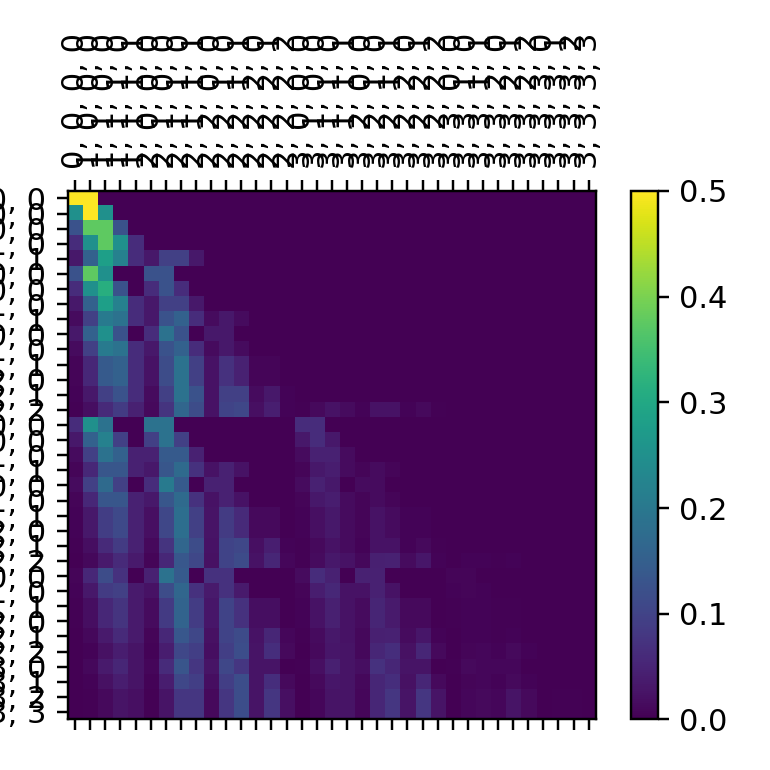

In [193]:
perb_matrix_rep, states = construct_perturbation_matrix_2(4, 3, 0.5, k=1)
display_mat(n_th_power_mat(perb_matrix_rep, 1), states, scale=0.5)